## Project NLP | Business Case: Automated Customer Reviews

In [1]:
import pandas as pd
from transformers import BertTokenizer
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from nltk.stem import PorterStemmer

In [2]:
# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load the Amazon product reviews dataset
data = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null   object 
 10  manufacturer         5000 non-null   object 
 11  manufacturerNumber   5000 non-null   object 
 12  reviews.date         5000 non-null   object 
 13  reviews.dateAdded    1052 non-null   object 
 14  reviews.dateSeen     5000 non-null   object 
 15  reviews.doRecommend  5000 non-null   b

In [5]:
data.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


In [6]:
data.isnull().sum()

,0
id,0
dateAdded,0
dateUpdated,0
name,0
asins,0
brand,0
categories,0
primaryCategories,0
imageURLs,0
keys,0


## Prepriseccing

In [7]:
import pandas as pd



# Drop rows with missing essential information
data.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# Text Cleaning
# Lowercase text
data['clean_text'] = data['reviews.text'].str.lower()

# Remove special characters and symbols
data['clean_text'] = data['clean_text'].str.replace('[^a-zA-Z\s]', '')



# Mapping Star Ratings to Sentiment Classes
def map_star_rating_to_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 'Negative'
    elif star_rating == 3:
        return 'Neutral'
    elif star_rating in [4, 5]:
        return 'Positive'

data['sentiment'] = data['reviews.rating'].apply(map_star_rating_to_sentiment)

# Calculate the total count of each sentiment class
sentiment_counts = data['sentiment'].value_counts()

# Display the total count of each sentiment class
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count}")



Positive: 4686
Neutral: 197
Negative: 117


# Visualize Star Ratings Distribution

<ipython-input-8-cc06fe422eaf>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='reviews.rating', palette='Blues')


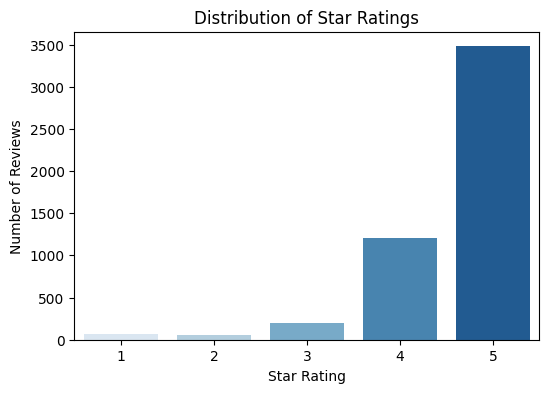

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='reviews.rating', palette='Blues')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.show()


In [9]:
# Undersample Positive Class
# First, check class distribution
print(data['sentiment'].value_counts())

# Separate the classes
positive_df = data[data['sentiment'] == 'Positive']
neutral_df = data[data['sentiment'] == 'Neutral']
negative_df = data[data['sentiment'] == 'Negative']

# Set undersample size to match the minority class
target_size = min(len(neutral_df), len(negative_df))  # smallest class size

# Undersample Positive class
positive_df_sampled = positive_df.sample(n=target_size, random_state=42)

# Combine all classes
balanced_df = pd.concat([positive_df_sampled, neutral_df, negative_df], axis=0)

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show new class distribution
print("\nBalanced Class Distribution:")
print(balanced_df['sentiment'].value_counts())


sentiment
Positive    4686
Neutral      197
Negative     117
Name: count, dtype: int64

Balanced Class Distribution:
sentiment
Neutral     197
Negative    117
Positive    117
Name: count, dtype: int64


<ipython-input-10-e5dedf28c94c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='sentiment', palette='Set2')


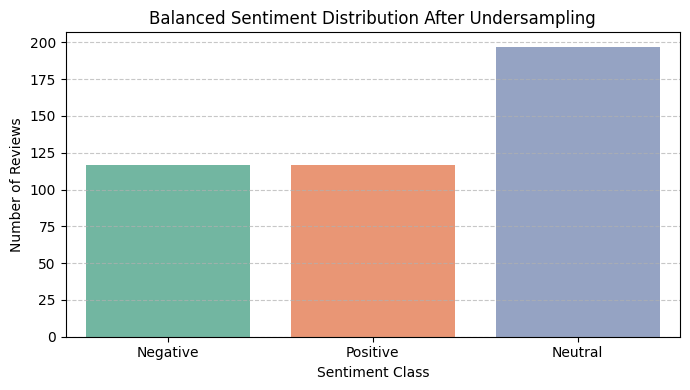

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.countplot(data=balanced_df, x='sentiment', palette='Set2')
plt.title('Balanced Sentiment Distribution After Undersampling')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [11]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = data['clean_text']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Task 1. Classification with pre-trained models.

## bert-base-uncased

In [ ]:
 # bert-base-uncased
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch



# Encode the labels if they are strings
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_mapping = {index: label for label, index in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 classes

# Tokenize the training and testing data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors='pt')

# Create PyTorch Dataset
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor([self.labels[idx]])  # Ensure labels are also tensors
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, y_train)
test_dataset = ReviewDataset(test_encodings, y_test)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./bert_logs',
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


Label Mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abrar-alanazi (abrar-alanazi-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test dataset
predictions = trainer.predict(test_dataset)
predicted_class = predictions.predictions.argmax(axis=-1)
true_class = y_test  # Use y_test as the true labels

# Calculate evaluation metrics
accuracy = accuracy_score(true_class, predicted_class)
precision, recall, f1, _ = precision_recall_fscore_support(true_class, predicted_class, average=None)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_class, predicted_class)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print classification report
print("Classification Report:")
print(classification_report(true_class, predicted_class, target_names=label_encoder.classes_))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# 1. Plot Training & Validation Loss
# -------------------------
logs_df = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(10, 5))
plt.plot(logs_df[logs_df['loss'].notnull()]['step'], logs_df[logs_df['loss'].notnull()]['loss'], label='Training Loss', color='blue')
plt.plot(logs_df[logs_df['eval_loss'].notnull()]['step'], logs_df[logs_df['eval_loss'].notnull()]['eval_loss'], label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the best model
model.save_pretrained('./best_bert_model')
tokenizer.save_pretrained('./best_bert_model')  # Also save the tokenizer

# Task 2. Product Category Clustering

Cluster
0    [TVs Entertainment, TV, Tvs & Home Theater, Vi...
1    [Kindle E-readers, E-Readers, E-Readers & Acce...
2    [Computers, Electronics Features, Electronics,...
3    [Virtual Assistant Speakers, Audio & Video Com...
4    [Tablets, iPad & Tablets, iPad Accessories, Us...
Name: Category, dtype: object


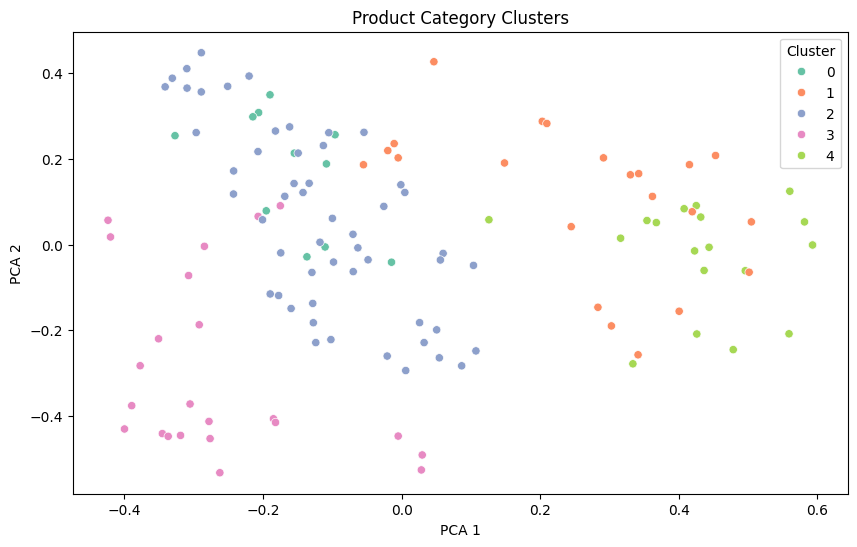

In [16]:
# Task 2: Product Category Clustering

import pandas as pd
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Extract and clean the category names
data['categories'] = data['categories'].astype(str).str.split(',')
all_categories = data['categories'].explode().str.strip().dropna().unique().tolist()

# Step 2: Generate embeddings using a transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast, small S-BERT model
category_embeddings = model.encode(all_categories)

# Step 3: Cluster the embeddings (adjust k based on needs)
k = 5  # Choose 4-6 depending on how broad you want
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(category_embeddings)

# Step 4: Create cluster mapping and assign to original data
cluster_mapping = dict(zip(all_categories, clusters))

def map_to_cluster(category_list):
    if not isinstance(category_list, list):
        return []
    return list(set(cluster_mapping.get(cat.strip(), -1) for cat in category_list))

data['category_cluster'] = data['categories'].apply(map_to_cluster)

# Show cluster labels and example categories
cluster_df = pd.DataFrame({'Category': all_categories, 'Cluster': clusters})
print(cluster_df.groupby('Cluster')['Category'].apply(list))

# Optional: Visualize using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(category_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=clusters, palette='Set2')
plt.title("Product Category Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()


# Task 3. Summarize reviews using generative AI

In [26]:
import pandas as pd

# Filter required columns
df_filtered = data[[
    "name", "brand", "categories", "primaryCategories", "reviews.rating",
    "reviews.text", "reviews.doRecommend"
]]

# Drop NaNs in important fields
df_filtered.dropna(subset=["reviews.rating", "reviews.text"], inplace=True)

# Group by product
grouped = df_filtered.groupby("name")

from collections import Counter
import numpy as np

def get_product_summary(group):
    reviews = group["reviews.text"].tolist()
    ratings = group["reviews.rating"].tolist()
    avg_rating = np.mean(ratings)
    complaints = [text for text, rating in zip(reviews, ratings) if rating <= 2]
    positives = [text for text, rating in zip(reviews, ratings) if rating >= 4]

    return {
        "avg_rating": avg_rating,
        "num_reviews": len(reviews),
        "complaints": complaints[:3],  # top complaints
        "positives": positives[:3]     # top praises
    }

product_summaries = {name: get_product_summary(group) for name, group in grouped}


# Organize products per category
from collections import defaultdict

category_products = defaultdict(list)

for name, group in grouped:
    category = group["primaryCategories"].iloc[0]
    summary = get_product_summary(group)
    category_products[category].append((name, summary))

# For each category: sort by avg rating
category_rankings = {}

for cat, products in category_products.items():
    sorted_products = sorted(products, key=lambda x: x[1]["avg_rating"], reverse=True)
    category_rankings[cat] = {
        "top3": sorted_products[:3],
        "worst": sorted_products[-1]
    }
from transformers import pipeline

# Use a pretrained summarization pipeline (can replace with 'facebook/bart-large-cnn' or 't5-base')
summarizer = pipeline("text2text-generation", model="t5-base", tokenizer="t5-base")

def generate_article(category, summary_data):
    article_prompt = f"""
Generate a short blog post recommending top tablets in the {category} category.

Top 3 Products:
1. {summary_data['top3'][0][0]} - {summary_data['top3'][0][1]['positives']}
2. {summary_data['top3'][1][0]} - {summary_data['top3'][1][1]['positives']}
3. {summary_data['top3'][2][0]} - {summary_data['top3'][2][1]['positives']}

Key Complaints:
- {summary_data['top3'][0][0]}: {summary_data['top3'][0][1]['complaints']}
- {summary_data['top3'][1][0]}: {summary_data['top3'][1][1]['complaints']}
- {summary_data['top3'][2][0]}: {summary_data['top3'][2][1]['complaints']}

Worst Product:
{summary_data['worst'][0]} - {summary_data['worst'][1]['complaints']}

Conclude with advice on what to buy and what to avoid.
"""
    result = summarizer(article_prompt, max_length=512, do_sample=True)
    return result[0]["generated_text"]

# Example
example_category = list(category_rankings.keys())[0]
article = generate_article(example_category, category_rankings[example_category])
print(article)


<ipython-input-26-df41b35af6df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=["reviews.rating", "reviews.text"], inplace=True)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


it seems like the model is out of warranty - Consumer Reports and - -. A short opinion on what to buy and what to avoid. - - - Amazon's top seller for tablets. ['[this] is not an upgrade by any means!'] . Also a great product at affordable price. . ['Amazon never gives up the opportunity.'] Great Price - $299+ . - and a list


In [27]:
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch


# -------------------- Preprocessing -------------------- #
# Group by product
def preprocess_reviews(df, category):
    category_df = data[data['primaryCategories'].str.contains(category, na=False)]

    product_stats = category_df.groupby('name').agg({
        'reviews.rating': ['mean', 'count'],
        'reviews.doRecommend': lambda x: np.mean(x == True),
        'reviews.text': list
    }).reset_index()

    product_stats.columns = ['product', 'avg_rating', 'review_count', 'recommend_rate', 'reviews']
    product_stats = product_stats.sort_values(by=['avg_rating', 'recommend_rate', 'review_count'], ascending=[False, False, False])

    top_3 = product_stats.head(3)
    worst = product_stats.tail(1)

    return top_3, worst

# Create input prompt for generation
def format_prompt(top_3, worst):
    prompt = "Write a short blog post recommending the best products in this category.\n\n"

    for i, row in top_3.iterrows():
        prompt += f"Product {i+1}: {row['product']}\n"
        prompt += f"Average Rating: {row['avg_rating']:.2f}\n"
        prompt += f"Recommend Rate: {row['recommend_rate']*100:.1f}%\n"
        prompt += f"Top Complaint: {extract_top_complaint(row['reviews'])}\n\n"

    prompt += f"Worst Product: {worst.iloc[0]['product']}\n"
    prompt += f"Rating: {worst.iloc[0]['avg_rating']:.2f}, Recommend Rate: {worst.iloc[0]['recommend_rate']*100:.1f}%\n"
    prompt += f"Main Complaint: {extract_top_complaint(worst.iloc[0]['reviews'])}\n"

    return prompt

def extract_top_complaint(reviews):
    # Naive method: most common short sentence or negative word pattern
    complaints = [r for r in reviews if "too" in r or "not" in r or "bad" in r]
    if complaints:
        return complaints[0][:150]
    else:
        return "No major complaints found."

# -------------------- Generation -------------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)
tokenizer = T5Tokenizer.from_pretrained("t5-base")

def generate_summary(prompt):
    input_ids = tokenizer("summarize: " + prompt, return_tensors="pt", max_length=1024, truncation=True).input_ids.to(device)
    outputs = model.generate(input_ids, max_length=512, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# -------------------- Run Example -------------------- #
top_3, worst = preprocess_reviews(data, category="Electronics")
prompt = format_prompt(top_3, worst)
summary = generate_summary(prompt)

print(summary)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Amazon Fire TV with 4k Ultra HD and Alexa Voice Remote (Pendant Design) Average Rating: 5.00 Recommend Rate: 100.0% Top Complaint: Really cool device!


In [28]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the pretrained T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

# Function to generate summaries
def generate_summary(reviews):
    # Preparing the text to be summarized
    input_text = "summarize: " + reviews
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)

    # Generating summary
    summary_ids = model.generate(inputs['input_ids'], max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example: Summarizing a product category's reviews
example_reviews = "This Kindle is lightweight, great for reading at the beach. However, the screen could be brighter in sunlight."
summary = generate_summary(example_reviews)
print(summary)


Kindle lightweight, great for reading at the beach . screen could be brighter in sunlight .
